In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten

In [ ]:
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 256)       104883

In [ ]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer - important trick!
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.

discriminator.compile( loss='binary_crossentropy')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 6, 6, 128)         0   

In [ ]:
def histogram_equalization(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate the histogram of the grayscale image
    hist, bins = np.histogram(gray_image.flatten(), 256, [0, 256])

    # Calculate the cumulative distribution function (CDF) of the histogram
    cdf = hist.cumsum()

    # Normalize the CDF to be in the range [0, 255]
    cdf_normalized = cdf * 255 / cdf[-1]

    # Use the CDF to map the intensity values of the image
    equalized_image = np.interp(gray_image.flatten(), bins[:-1], cdf_normalized)

    # Reshape the equalized image to match the original shape
    equalized_image = equalized_image.reshape(gray_image.shape)

    # Convert the equalized image back to 8-bit unsigned integer format
    equalized_image = np.uint8(equalized_image)

    return equalized_image

# Load an image from file
input_image = cv2.imread('input_image.jpg')

# Perform histogram equalization
equalized_image = histogram_equalization(input_image)

In [ ]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan.compile(loss='binary_crossentropy')
gan.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32)]              0         
                                                                 
 model (Functional)          (None, 32, 32, 3)         6264579   
                                                                 
 model_2 (Functional)        (None, 1)                 790913    
                                                                 
Total params: 7055492 (26.91 MB)
Trainable params: 6264579 (23.90 MB)
Non-trainable params: 790913 (3.02 MB)
_________________________________________________________________


In [ ]:
import os
from keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]

# Normalize data
model = Sequential()
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 200000
batch_size = 20
save_dir = './output/gan_images/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('./output/gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

In [ ]:
learning_rate = .1
n_epochs = 500
n_clients = 5
client_batch_size = 5
n_rounds = 10
ls_accuracy = []

with tf.Session() as sess:
    Worker = Node(sess, n_features, n_classes)
    sess.run(tf.global_variables_initializer())

    for r in range(n_rounds):
        s = time()

        # each round needs a new average client weights
        ls_client_w1 = []

        for client in range(n_clients):

            # each client receives the same server weight
            client_w1 = server_w1

            # each client has their own minibatch
            X_client, y_client = fetch_minibatch(X_full, y_full, client_batch_size)

            # calculate term b gradient using (1) server weights and (2) client data
            term_b = Worker.fetch_grad(server_w1, X_client, y_client)

            # compute term c gradient using (1) server weights and (2) server data
            term_c = Worker.fetch_grad(server_w1, X_server, y_server)

            # client parameter updates
            for n in range(n_epochs):
                # compute term a gradient using (1) client weights and (2) client data
                term_a = Worker.fetch_grad(client_w1, X_client, y_client)

                # update client weights
                client_w1 = client_w1 - learning_rate * (term_a - term_b + term_c)

            # track weights for each client
            ls_client_w1.append(client_w1)

        # after all clients are accounted for, update server weights each round
        server_w1 = np.mean(ls_client_w1, axis=0)
        Worker.load(server_w1)
        acc = Worker.score(X_full, y_full)
        print("round {} execution time: {} accuracy: {}".format(r, time() - s, acc))
        ls_accuracy.append(acc)


print("Accuracy:",acc)


Accuracy: 0.902714


In [ ]:
# Use the palm.list_models function to find available models:
models = [m for m in palm.list_models() if 'generateText' in m.supported_generation_methods]
model = models[0].name
print(model)

In [ ]:
history = model.fit(x_train,y_train,epochs=2,validation_split=0.2)

In [ ]:
import requests
from PIL import Image
from io import BytesIO

def read_image_from_url(url):
    try:
        # Send a GET request to the URL
        response = requests.get(url)
        if response.status_code == 200:
            # Open the image using PIL
            image = Image.open(BytesIO(response.content))

            # You can now work with the 'image' object
            # For example, you can display it:
            image.show()

            # Or save it to a file:
            image.save("downloaded_image.jpg")
        else:
            print("Failed to retrieve the image. Status code:", response.status_code)
    except Exception as e:
        print("An error occurred:", str(e))

# Replace 'your_image_url' with the actual URL of the image you want to download
image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZNEzVhKOLWvBo2FFf4X3JBd1VROGaTUyxiQ&usqp=CAU'
img = read_image_from_url(image_url)


In [ ]:
def classify(image_path):
  # Generate a completion using the PALM model
  completion = palm.generate_text(
      model=model,
      prompt=get_prompt(image_path),
      temperature=0,
      max_output_tokens=200,
  )

  # Get the completion result
  result = completion.result
  if(result == None):return "Synthetic"
  answer = result.split('\n')[-1].strip()

  # Return the answer
  return answer

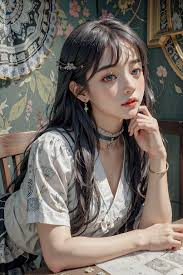

Synthetic


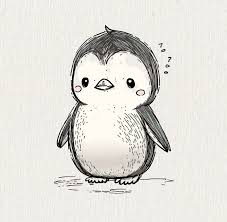

Real


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import urllib.request
import numpy as np

# Image link
image_link = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZNEzVhKOLWvBo2FFf4X3JBd1VROGaTUyxiQ&usqp=CAU"
image_link2 = "https://media.vogue.co.uk/photos/63611d51cf716662f02c80fb/1:1/w_2160,h_2160,c_limit/Selena_Photo%20brightened.jpg"

# Read the image from the link
resp = urllib.request.urlopen(image_link)
resp2 = urllib.request.urlopen(image_link2)
image_array = np.asarray(bytearray(resp.read()), dtype="uint8")
image_array2 = np.asarray(bytearray(resp2.read()), dtype="uint8")
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
image2 = cv2.imdecode(image_array2, cv2.IMREAD_COLOR)

# Display the image
cv2_imshow(image)
res = classify(image)
print(res)
cv2_imshow(image2)
res = classify(image2)
res